<a href="https://colab.research.google.com/github/kjprice/smu-capstone/blob/master/notebooks/ASL_Signs_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os, shutil, copy, ntpath, datetime, zipfile
import keras
from keras import models, layers, callbacks

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import boto3
import glob
import ntpath
import re

import numpy as np
import pandas as pd

## Make sure we have GPU

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Settings

In [0]:
IMAGE_SHAPE=(150, 150, 3)

#LIMIT_BATCHES = 593
LIMIT_BATCHES = None

NUM_EPOCHS = 10
BATCH_SIZE = 20
NUM_CLASSES = 29

# PRETRAIN_MODEL = 'conv_base_local'
#PRETRAIN_MODEL = VGG16
#PRETRAIN_MODEL = VGG19
PRETRAIN_MODEL = Xception
#PRETRAIN_MODEL = ResNet50
# PRETRAIN_MODEL = None

USE_PREPROCESSED_IMAGES = False

TEST_TRAIN_SPLIT = .95 # Train Size

#### Set Folders

In [0]:
#### FilePath Information
DATA_DIR = '/content/gdrive/My Drive/SMU/Capstone/DataSets/'

LOCAL_DATASET_DIR = '/tmp/asl_alphabet'

SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_alphabet')

In [0]:
if USE_PREPROCESSED_IMAGES:
  dataset_zip = os.path.join(DATA_DIR, 'asl_alphabet.zip')
  local_dataset_zip = '/tmp/asl_alphabet.zip'
  train_dataset_name = 'processed_asl_train'
  temp_unzip_directory = '/tmp/data/fabricated/asl_alphabet'
else:
  dataset_zip = os.path.join(DATA_DIR, 'asl_alphabet_original.zip')
  local_dataset_zip = '/tmp/asl_alphabet_original.zip'
  train_dataset_name = 'split_asl_alphabet_train'
  temp_unzip_directory = '/tmp/asl_alphabet_original/data/fabricated/asl_alphabet'
  
TRAIN_DATASET_NAME = train_dataset_name
ASL_ALPHABET_DATASET_ZIP = dataset_zip
LOCAL_DATASET_ZIP = local_dataset_zip
LOCAL_TRAIN_DIR = os.path.join(LOCAL_DATASET_DIR, TRAIN_DATASET_NAME)
TEMP_UNZIP_DIRECTORY = temp_unzip_directory

#### Download Data

In [0]:
if not os.path.isfile(LOCAL_DATASET_ZIP):
  %time shutil.copy(ASL_ALPHABET_DATASET_ZIP, LOCAL_DATASET_ZIP)


#### Extract Data

In [8]:
if os.path.isdir(LOCAL_DATASET_DIR):
  shutil.rmtree(LOCAL_DATASET_DIR)
with zipfile.ZipFile(LOCAL_DATASET_ZIP, 'r') as zip_ref:
    %time zip_ref.extractall('/tmp')

CPU times: user 17.3 s, sys: 6.11 s, total: 23.4 s
Wall time: 23.8 s


In [0]:
if not os.path.isdir(TEMP_UNZIP_DIRECTORY):
  print('not sure where the zip folder exported the directory but it is not where we expected')
else:
  shutil.move(TEMP_UNZIP_DIRECTORY, LOCAL_DATASET_DIR)

In [10]:
AVAILABLE_DATASETS = os.listdir(LOCAL_DATASET_DIR)
print(AVAILABLE_DATASETS)

['split_asl_alphabet_train', 'split_asl_alphabet_test']


In [11]:
if not TRAIN_DATASET_NAME in AVAILABLE_DATASETS:
  raise Exception('we are expecting to see {} as one of the available datasets'.format(TRAIN_DATASET_NAME))
TEST_DATASET_NAMES = [dataset for dataset in AVAILABLE_DATASETS if dataset != TRAIN_DATASET_NAME]
print('We have one training set and {} test sets'.format(len(TEST_DATASET_NAMES)))
LOCAL_TEST_DIRS = [os.path.join(LOCAL_DATASET_DIR, name) for name in TEST_DATASET_NAMES]

We have one training set and 1 test sets


#### Create Split training/test data

In [0]:
def get_sign_folders(from_folder):
  # https://stackoverflow.com/questions/973473/getting-a-list-of-all-subdirectories-in-the-current-directory
  folders = next(os.walk(from_folder))[1]
  return folders

In [0]:
# A, B, C, D, DELETE, etc
ASL_FOLDERS = get_sign_folders(LOCAL_TRAIN_DIR)

#### Create Data Generators

In [0]:
def create_test_datagen(directory):
  test_datagen = ImageDataGenerator(rescale=1./255)
  return test_datagen.flow_from_directory(
         directory,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
  )

In [0]:
# dataset definition with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    )

In [16]:
#create generators
train_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='training'
)

#create generators
validation_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='validation'
)

test_generators = [create_test_datagen(dir) for dir in LOCAL_TEST_DIRS]

Found 74385 images belonging to 29 classes.
Found 8265 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.


# Models

In [0]:
def create_pretrained_model(BASE):   
    conv_base = BASE(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
    print(conv_base.summary())
    
    conv_base.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(29, activation='sigmoid'))

    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model
    
    

In [0]:
def create_blank_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMAGE_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))

    #Add a classfier on top of the convnet
    model.add(layers.Flatten())
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(128, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    #compile the model
    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    return model


In [19]:
if not PRETRAIN_MODEL:
    model = create_blank_model()
else:
    model = create_pretrained_model(PRETRAIN_MODEL)

83689472/83683744 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________

In [20]:
steps_per_epoch = None

if LIMIT_BATCHES is None:
  steps_per_epoch_train = len(train_generator)
  steps_per_epoch_val = len(validation_generator)
  steps_per_epoch_test = len(test_generators[0])
else:
  steps_per_epoch_train = LIMIT_BATCHES
  steps_per_epoch_val = (LIMIT_BATCHES / len(train_generator)) * len(validation_generator)
  steps_per_epoch_test = (LIMIT_BATCHES / len(train_generator)) * len(test_generators[0])

print('total batches {}'.format(len(train_generator)))
print('steps_per_epoch_train {}'.format(steps_per_epoch_train))
print('steps_per_epoch_test {}'.format(steps_per_epoch_test))
print('steps_per_epoch_val {}'.format(steps_per_epoch_val))


total batches 3720
steps_per_epoch_train 3720
steps_per_epoch_test 218
steps_per_epoch_val 414


In [21]:

history= model.fit_generator (
train_generator,
epochs = NUM_EPOCHS,
steps_per_epoch=steps_per_epoch_train,
validation_steps=steps_per_epoch_val,
#callbacks = callbacks_list,
validation_data=validation_generator,
verbose=1 \
)

Epoch 1/10
3720/3720 [==============================] - 707s 190ms/step - loss: 1.5749 - acc: 0.5742 - val_loss: 7.7655 - val_acc: 0.1685
Epoch 2/10
3720/3720 [==============================] - 702s 189ms/step - loss: 1.1095 - acc: 0.6995 - val_loss: 8.3507 - val_acc: 0.1869
Epoch 3/10
3720/3720 [==============================] - 704s 189ms/step - loss: 0.9583 - acc: 0.7375 - val_loss: 8.5505 - val_acc: 0.1860
Epoch 4/10
3720/3720 [==============================] - 705s 189ms/step - loss: 0.8634 - acc: 0.7609 - val_loss: 9.5710 - val_acc: 0.1625
Epoch 5/10
3720/3720 [==============================] - 698s 188ms/step - loss: 0.0641 - acc: 0.0952 - val_loss: 1.1921e-07 - val_acc: 0.0345
Epoch 6/10
3720/3720 [==============================] - 694s 187ms/step - loss: 1.1921e-07 - acc: 0.0345 - val_loss: 1.1921e-07 - val_acc: 0.0345
Epoch 7/10
3720/3720 [==============================] - 705s 189ms/step - loss: 1.1921e-07 - acc: 0.0345 - val_loss: 1.1921e-07 - val_acc: 0.0345
Epoch 8/10
372

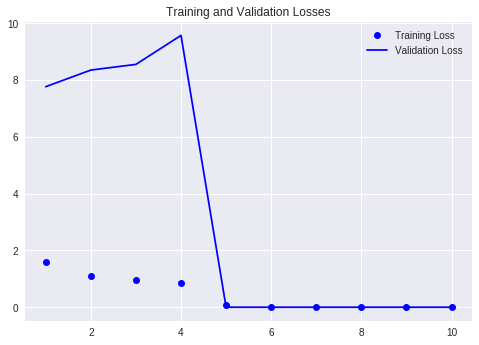

In [22]:
#visualization of model performance
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values =  history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs,val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel='Epochs'
plt.ylabel='Loss'
plt.legend()
plt.show()

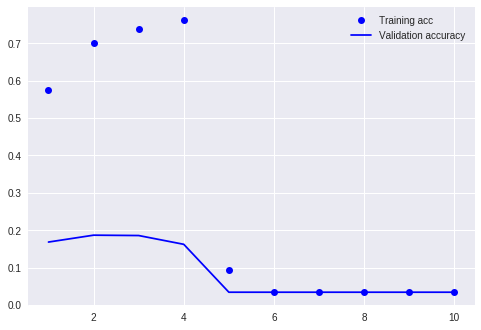

In [23]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs,val_acc_values, 'b', label='Validation accuracy')
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.legend()

plt.show()

## Validate against each of the test generators

In [24]:
for generator, _dir in zip(test_generators, LOCAL_TEST_DIRS):
  test_loss, test_acc = model.evaluate_generator(generator, steps=steps_per_epoch_test)
  print('{}: {}'.format(_dir, test_acc))

/tmp/asl_alphabet/split_asl_alphabet_test: 0.034482759237289426
